In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
features = [
    "sym_Jet0_pt", "sym_Jet1_pt", "sym_Jet2_pt", "sym_Jet3_pt",
    "sym_Jet0_eta", "sym_Jet1_eta", "sym_Jet2_eta", "sym_Jet3_eta",
    "sym_Jet0_phi", "sym_Jet1_phi", "sym_Jet2_phi", "sym_Jet3_phi",  
    "sym_Jet0_m", "sym_Jet1_m", "sym_Jet2_m", "sym_Jet3_m",
]

0it [00:00, ?it/s]

successfully loaded {'experiment_name': 'fvt_training_n_samples_1', 'seed': 42, 'n_sample_ratio': 1.0}


1it [00:06,  6.66s/it]

n_sample_ratio=1.0


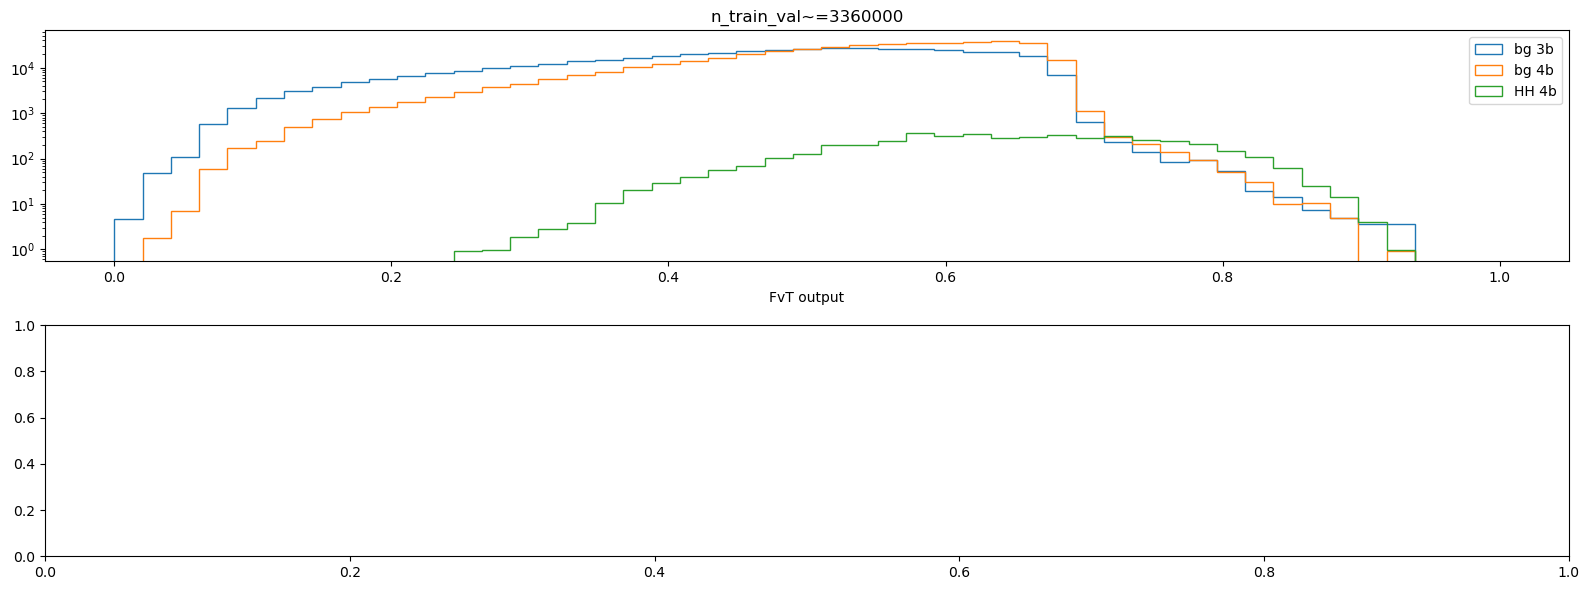

0it [00:00, ?it/s]

successfully loaded {'experiment_name': 'fvt_training_n_samples_1', 'seed': 52, 'n_sample_ratio': 1.0}


1it [00:06,  6.08s/it]

n_sample_ratio=1.0


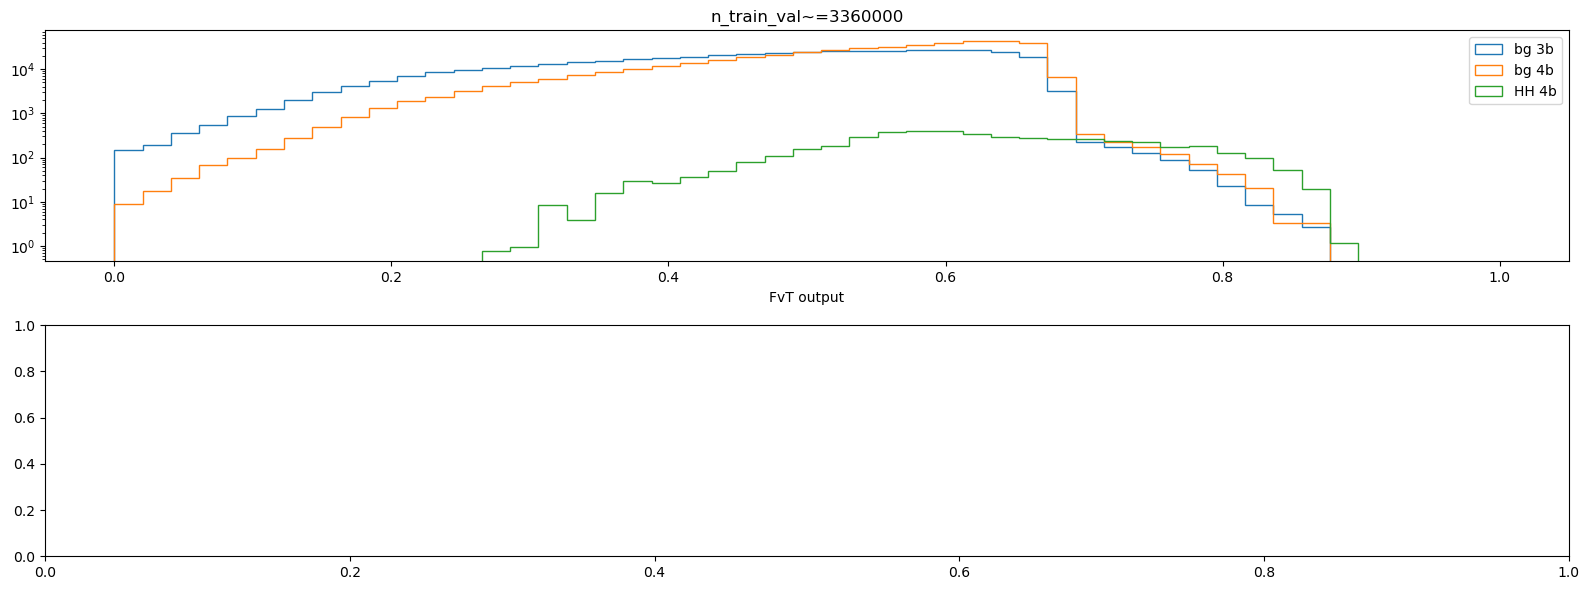

0it [00:00, ?it/s]

successfully loaded {'experiment_name': 'fvt_training_n_samples_1', 'seed': 62, 'n_sample_ratio': 1.0}


1it [00:06,  6.14s/it]

n_sample_ratio=1.0


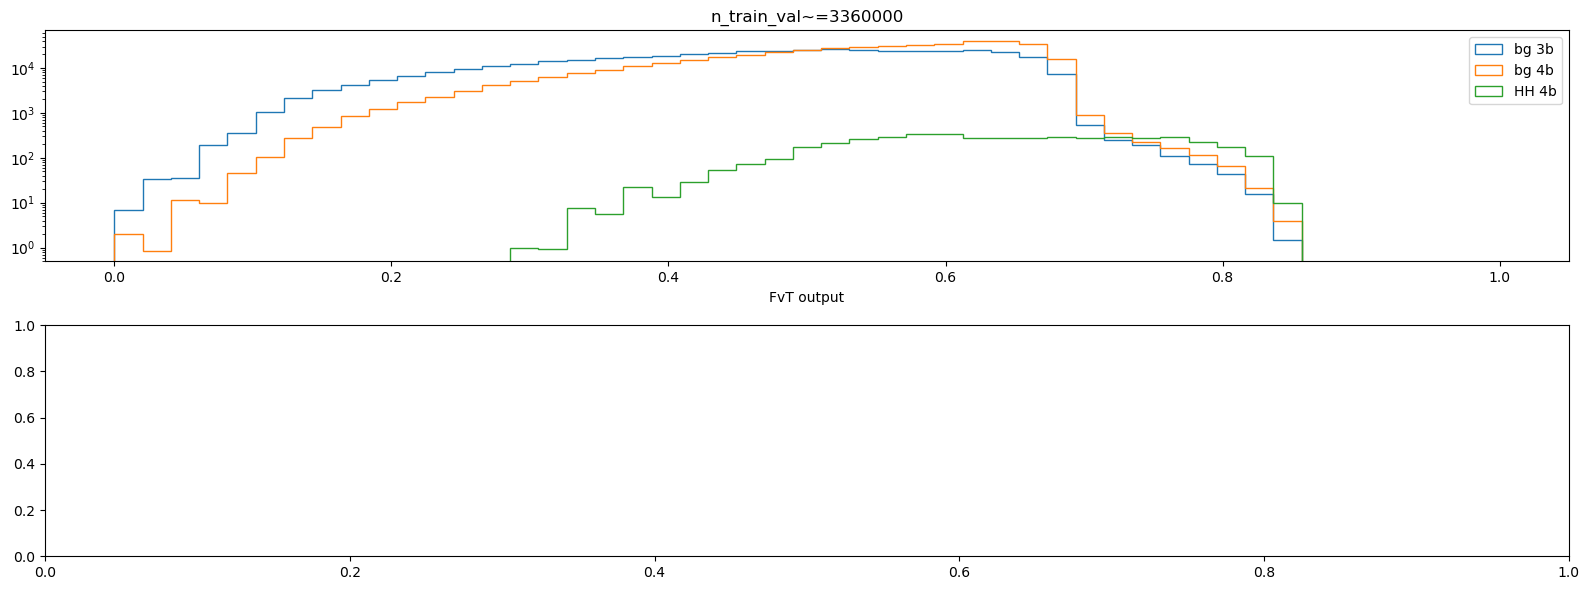

0it [00:00, ?it/s]

successfully loaded {'experiment_name': 'fvt_training_n_samples_1', 'seed': 72, 'n_sample_ratio': 1.0}


1it [00:06,  6.07s/it]

n_sample_ratio=1.0


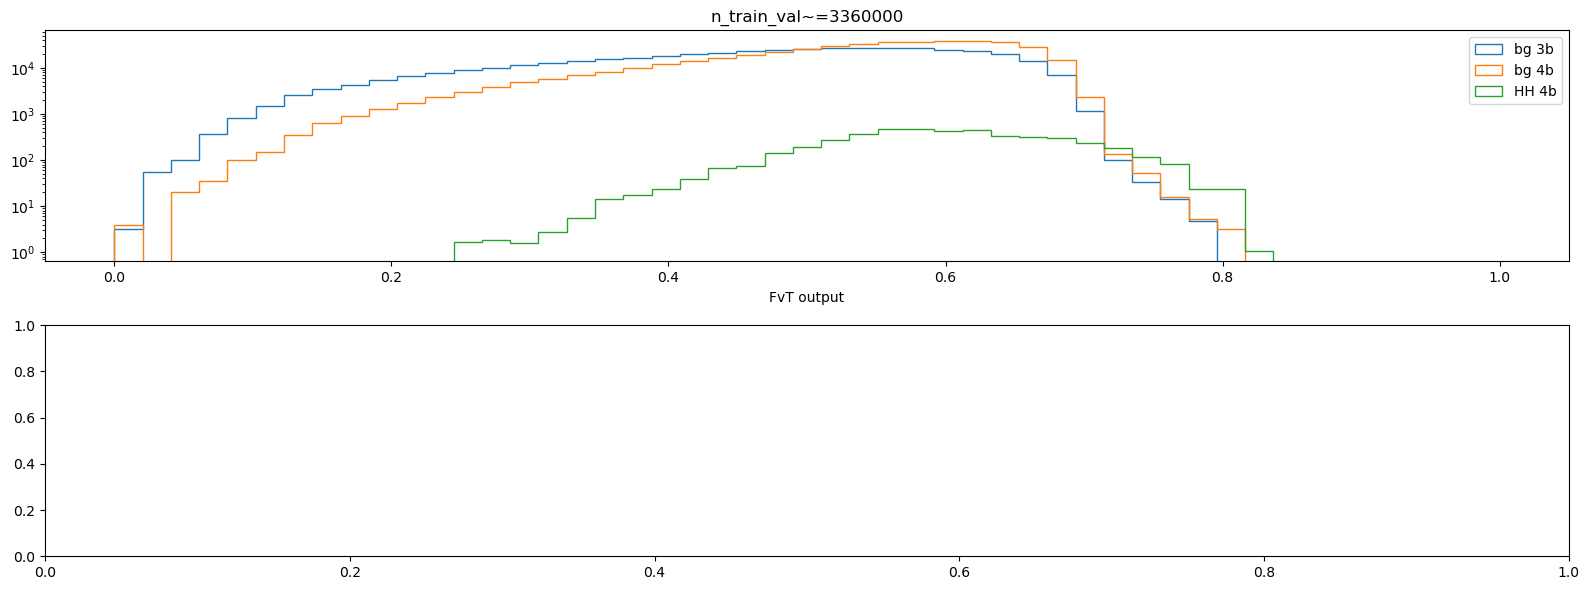

0it [00:00, ?it/s]

successfully loaded {'experiment_name': 'fvt_training_n_samples_1', 'seed': 82, 'n_sample_ratio': 1.0}


1it [00:06,  6.14s/it]

n_sample_ratio=1.0


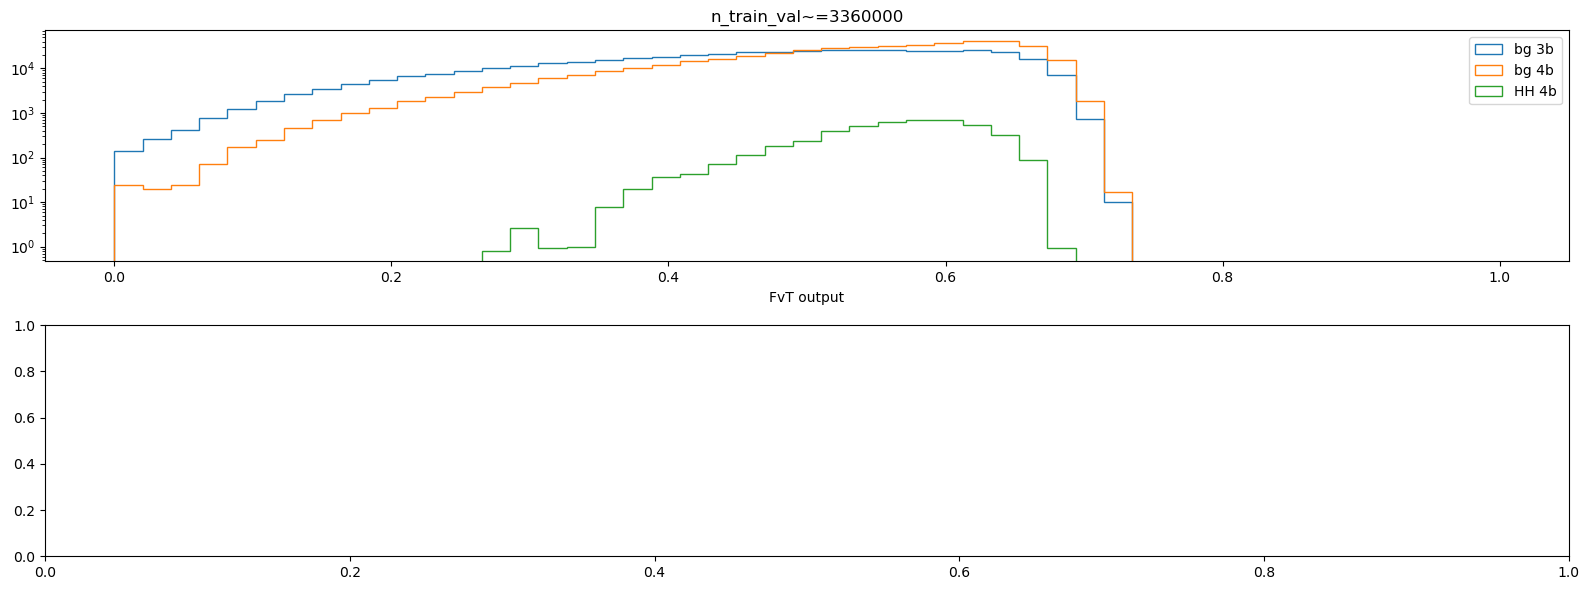

0it [00:00, ?it/s]

successfully loaded {'experiment_name': 'fvt_training_n_samples_1', 'seed': 92, 'n_sample_ratio': 1.0}


1it [00:06,  6.19s/it]

n_sample_ratio=1.0


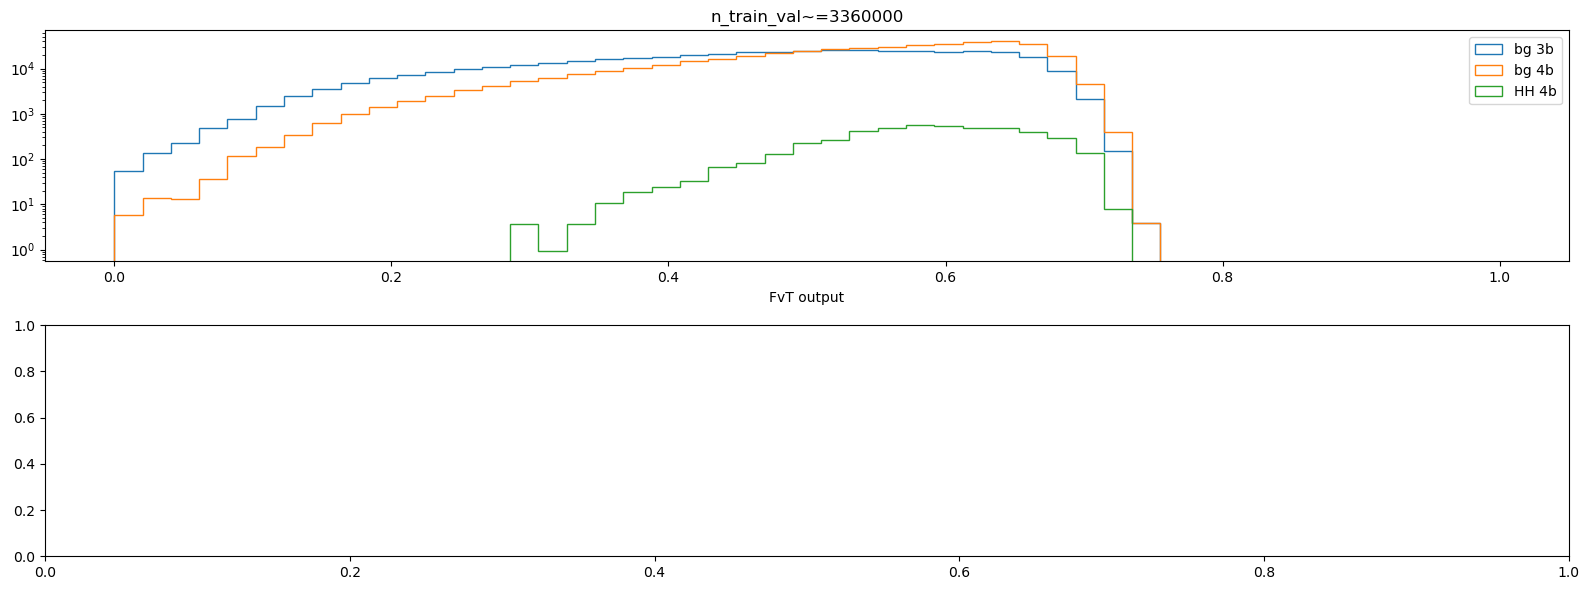

In [3]:
import torch
from dataset import generate_tt_dataset
from training_info import TrainingInfo
import pytorch_lightning as pl
import yaml
from fvt_classifier import FvTClassifier
from code_fragments import fvt_score_hist
from events_data import EventsData
import tqdm
import numpy as np
import matplotlib.pyplot as plt

config_filename = "configs/fvt_training_n_samples_1.yml"


config = yaml.safe_load(open(config_filename, "r"))
experiment_name = config["experiment_name"]
n_3b = config["n_3b"]
n_all4b = config["n_all4b"]
signal_ratio = config["signal_ratio"]
test_ratio = config["test_ratio"]
# n_sample_ratios = config["n_sample_ratios"]
n_sample_ratios = [1.0]
seeds = [42, 52, 62, 72, 82, 92]
w_cuts = np.arange(0.01, 1.01, 0.01)

fvt_scores_dict = {seed: {} for seed in seeds}
att_q_reprs_dict = {seed: {} for seed in seeds}
events_test_dict = {}
fvt_models_dict = {seed: {} for seed in seeds}

for seed in seeds:
    _, dinfo_test = generate_tt_dataset(
            seed,
            n_3b,
            n_all4b,
            signal_ratio,
            test_ratio,
        )
    events_test = EventsData.from_dataframe(dinfo_test.fetch_data(), features)
    events_test_dict[seed] = events_test

    nrows = 2
    ncols = int(np.ceil(len(n_sample_ratios) / 2))
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 6))

    for ax_cnt, n_sample_ratio in tqdm.tqdm(enumerate(n_sample_ratios)):
        hparam_filter = {"experiment_name": experiment_name, 
                         "seed": seed, 
                         "n_sample_ratio": n_sample_ratio}
        hashes = TrainingInfo.find(hparam_filter)
        assert len(hashes) == 1
        print("successfully loaded", hparam_filter)
        hash = hashes[0]
        tinfo = TrainingInfo.load(hash)
        fvt_model = FvTClassifier.load_from_checkpoint(f"./checkpoints/{hash}_best.ckpt")
        fvt_model.eval()

        current_ax = ax[ax_cnt // ncols, ax_cnt % ncols] if ncols > 1 else ax[ax_cnt]
        current_ax.set_title(f"n_train_val~={1000 * ((len(tinfo.dinfo_train) + len(tinfo.dinfo_val)) // 1000)}")
        device = torch.device("cuda:0")
        fvt_model = fvt_model.to(device)
        events_test.set_model_scores(fvt_model)
        fvt_score_hist(events_test, current_ax, logscale=True)
        
        print(f"n_sample_ratio={n_sample_ratio}")
        # att_q_repr_hist(events_test, title=f"n_sample_ratio={n_sample_ratio}")

        fvt_scores_dict[seed][n_sample_ratio] = events_test.fvt_score
        att_q_reprs_dict[seed][n_sample_ratio] = events_test.att_q_repr
        fvt_models_dict[seed][n_sample_ratio] = fvt_model

    fig.tight_layout()
    fig.show()

    plt.show()
    plt.close()

In [4]:
import logging
import tqdm
logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)
logging.getLogger("lightning").setLevel(logging.WARNING)

n_sample_ratio = 1.0
device = torch.device("cuda:0")
noise_scales = [0.025, 0.05, 0.1, 0.2]
peak_pcts = [0.1**2, 0.05**2, 0.025**2]

In [5]:
def plot_sr_stats(events, sr_stats, ax, label, **plot_kwargs):
    assert len(events) == len(sr_stats)

    sr_stats_argsort = np.argsort(sr_stats)[::-1]
    weights = events.weights[sr_stats_argsort]
    is_signal = events.is_signal[sr_stats_argsort]
    is_4b = events.is_4b[sr_stats_argsort]

    ax.plot(
        np.cumsum(weights * is_4b) / np.sum(weights * is_4b),
        np.cumsum(weights * is_signal) / np.sum(weights * is_signal),           
        label=label,
        **plot_kwargs,
    )

In [7]:
from signal_region import get_regions_stats


seed = 42
noise_scale = 0.1
hparam_filter = {"experiment_name": experiment_name, 
                    "seed": seed, 
                    "n_sample_ratio": n_sample_ratio}
hashes = TrainingInfo.find(hparam_filter)
assert len(hashes) == 1
print("successfully loaded", hparam_filter)
fvt_hash = hashes[0]

events_sr_train, events_sr_eval = events_test_dict[seed].split(1/3, seed=seed)

signal_region_stats = get_regions_stats(
    events_sr_eval, fvt_hash, method="smearing", 
    events_sr_train=events_sr_train, noise_scale=noise_scale)

successfully loaded {'experiment_name': 'fvt_training_n_samples_1', 'seed': 42, 'n_sample_ratio': 1.0}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=10` reached.


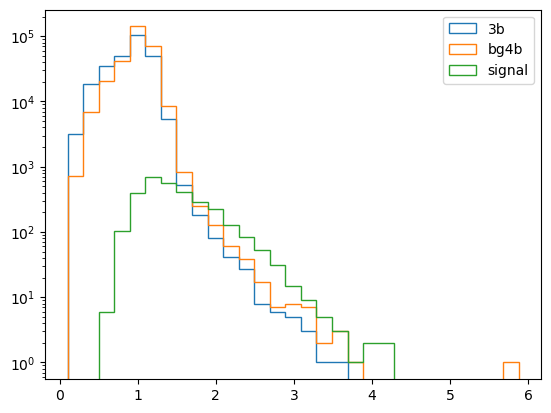

In [8]:
is_3b = events_sr_eval.is_3b
is_bg4b = events_sr_eval.is_bg4b
is_signal = events_sr_eval.is_signal

bins = np.linspace(np.min(signal_region_stats), np.max(signal_region_stats), 30)
plt.hist(signal_region_stats[is_3b], label="3b", histtype="step", bins=bins)
plt.hist(signal_region_stats[is_bg4b], label="bg4b", histtype="step", bins=bins)
plt.hist(signal_region_stats[is_signal], label="signal", histtype="step", bins=bins)
plt.yscale("log")
plt.legend()
plt.show()

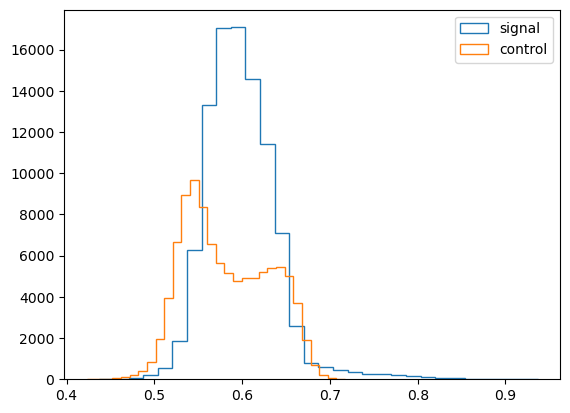

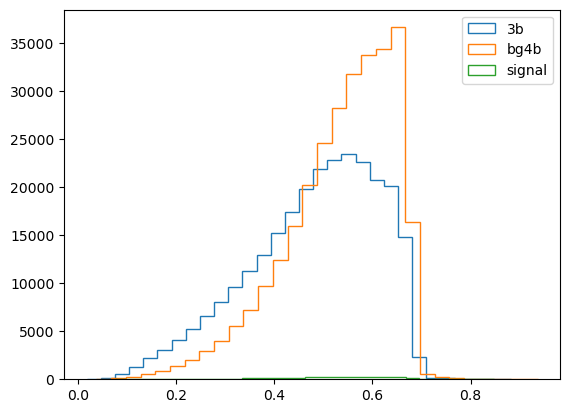

In [26]:
sr_w4b_ratio = 0.2
cr_w4b_ratio = 0.2

signal_region_stats_argsort = np.argsort(signal_region_stats)[::-1]
weights = events_sr_eval.weights[signal_region_stats_argsort]
is_signal = events_sr_eval.is_signal[signal_region_stats_argsort]
is_4b = events_sr_eval.is_4b[signal_region_stats_argsort]

cumul_4b_ratio = np.cumsum(weights * is_4b) / np.sum(weights * is_4b)
sr_cut_index = np.argmin(cumul_4b_ratio < sr_w4b_ratio)
cr_cut_index = np.argmin(cumul_4b_ratio < sr_w4b_ratio + cr_w4b_ratio)
signal_samples = signal_region_stats_argsort[:sr_cut_index]
control_samples = signal_region_stats_argsort[sr_cut_index:cr_cut_index]

plt.hist(events_sr_eval.fvt_score[signal_samples], bins=30, histtype="step", label="signal")
plt.hist(events_sr_eval.fvt_score[control_samples], bins=30, histtype="step", label="control")
# plt.yscale("log")
plt.legend()
plt.show()

plt.hist(events_sr_eval.fvt_score[is_3b], bins=30, histtype="step", label="3b")
plt.hist(events_sr_eval.fvt_score[is_bg4b], bins=30, histtype="step", label="bg4b")
plt.hist(events_sr_eval.fvt_score[is_signal], bins=30, histtype="step", label="signal")
# plt.yscale("log")
plt.legend()
plt.show()

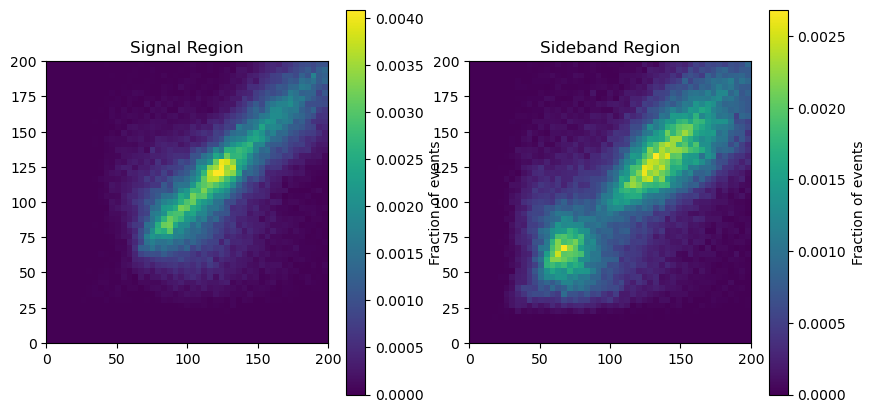

In [27]:
from ancillary_features import jets_to_dijets


jet0 = events_sr_eval.X_torch[:, [4*i for i in range(4)]]
jet1 = events_sr_eval.X_torch[:, [4*i + 1 for i in range(4)]]
jet2 = events_sr_eval.X_torch[:, [4*i + 2 for i in range(4)]]
jet3 = events_sr_eval.X_torch[:, [4*i + 3 for i in range(4)]]

dijet01, dijet23, dijet02, dijet13, dijet03, dijet12 = jets_to_dijets(jet0, jet1, jet2, jet3, dim=2)
M01, M23, M02, M13, M03, M12 = dijet01[:, 3], dijet23[:, 3], dijet02[:, 3], dijet13[:, 3], dijet03[:, 3], dijet12[:, 3]
M01, M23, M02, M13, M03, M12 = M01.cpu().numpy(), M23.cpu().numpy(), M02.cpu().numpy(), M13.cpu().numpy(), M03.cpu().numpy(), M12.cpu().numpy()

m_diff = np.stack(
    [M01 - M23, M02 - M13, M03 - M12],
    axis=1
)
m_diff_argmin = np.argmin(np.abs(m_diff), axis=1)

m_0 = np.where(m_diff_argmin == 0, M01, np.where(m_diff_argmin == 1, M02, M03))
m_1 = np.where(m_diff_argmin == 0, M23, np.where(m_diff_argmin == 1, M13, M12))

x_bins = np.linspace(0, 200, 50)
y_bins = np.linspace(0, 200, 50)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

hist_sr, _, _ = np.histogram2d(m_0[signal_samples], m_1[signal_samples], bins=(x_bins, y_bins), weights=events_sr_eval.weights[signal_samples])
hist_sb, _, _ = np.histogram2d(m_0[control_samples], m_1[control_samples], bins=(x_bins, y_bins), weights=events_sr_eval.weights[control_samples])

hist_sr = hist_sr.T
hist_sb = hist_sb.T

hist_sr /= np.sum(hist_sr)
hist_sb /= np.sum(hist_sb)

im = ax[0].imshow(hist_sr, extent=(x_bins[0], x_bins[-1], y_bins[0], y_bins[-1]), origin="lower", cmap="viridis")
cbar = plt.colorbar(im, ax=ax[0])
cbar.set_label("Fraction of events")
ax[0].set_title("Signal Region")

im = ax[1].imshow(hist_sb, extent=(x_bins[0], x_bins[-1], y_bins[0], y_bins[-1]), origin="lower", cmap="viridis")
cbar = plt.colorbar(im, ax=ax[1])
cbar.set_label("Fraction of events")
ax[1].set_title("Sideband Region")


plt.show()
plt.close()


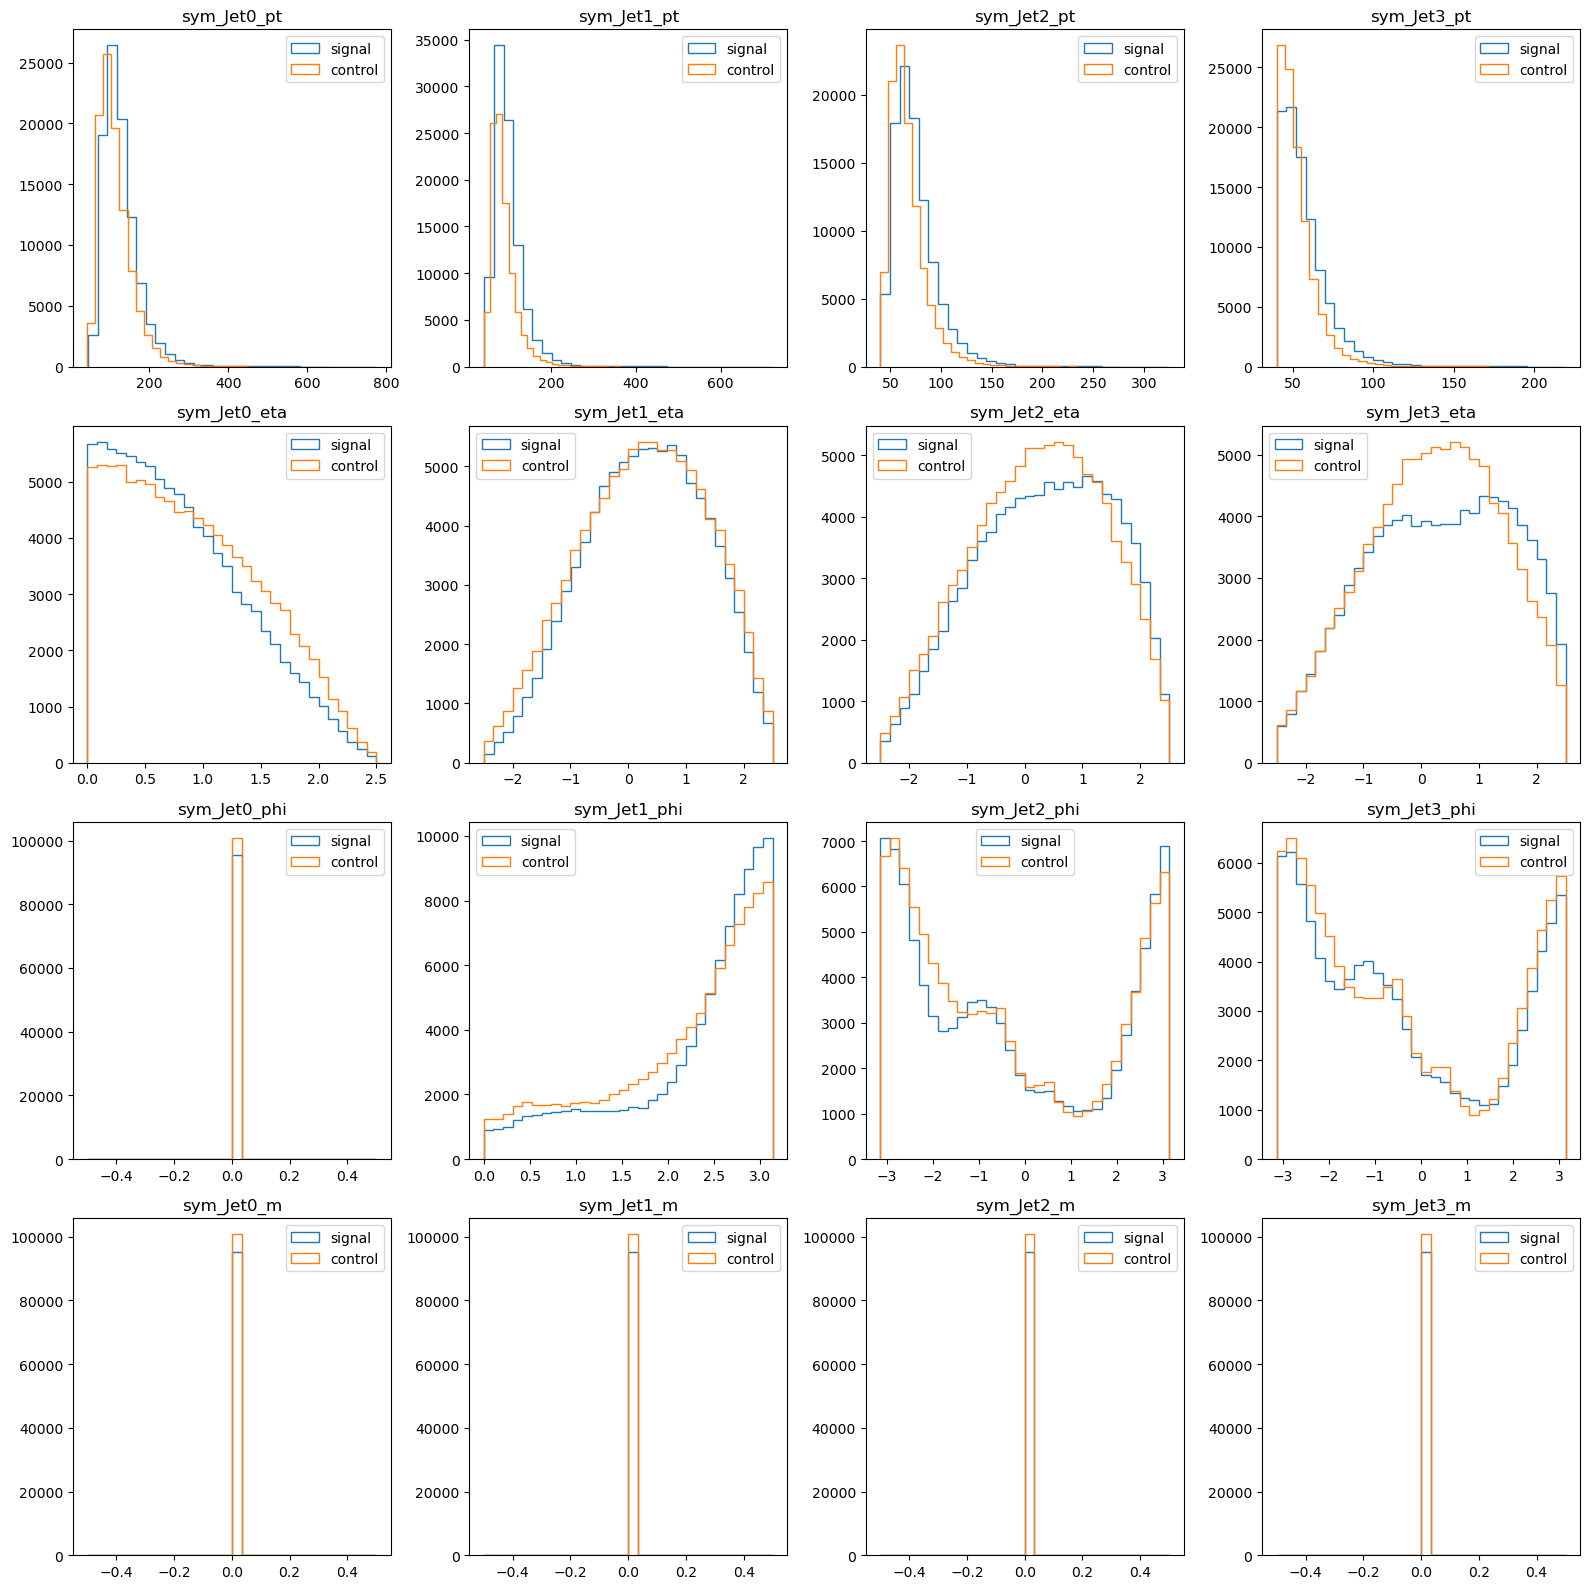

In [32]:
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(16, 16))

for i, feature in enumerate(features):
    current_ax = ax[i // 4, i % 4]
    current_ax.set_title(feature)
    current_ax.hist(events_sr_eval.X[signal_samples, i], bins=30, histtype="step", label="signal")
    current_ax.hist(events_sr_eval.X[control_samples, i], bins=30, histtype="step", label="control")
    current_ax.legend()

fig.tight_layout()
fig.show()
plt.show()
plt.close()


successfully loaded {'experiment_name': 'fvt_training_n_samples_1', 'seed': 42, 'n_sample_ratio': 1.0}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/soheuny/miniconda3/envs/coffea_torch/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /home/soheuny/HH4bsim/playground/checkpoints exists and is not empty.


Epoch 16: 100%|██████████| 66/66 [00:02<00:00, 28.75it/s, v_num=1, val_loss=0.679, train_loss=0.676]
CR w_4b / w_3b = 1.3810327053070068
SR w_4b / w_3b = 1.5039342641830444


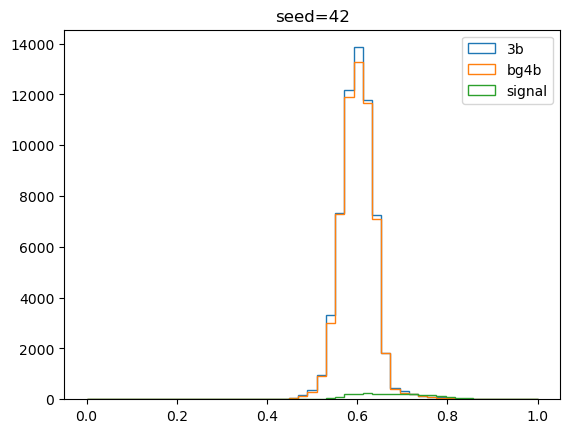

successfully loaded {'experiment_name': 'fvt_training_n_samples_1', 'seed': 52, 'n_sample_ratio': 1.0}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 29: 100%|██████████| 65/65 [00:01<00:00, 32.94it/s, v_num=0, val_loss=0.676, train_loss=0.676]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 65/65 [00:01<00:00, 32.68it/s, v_num=0, val_loss=0.676, train_loss=0.676]
CR w_4b / w_3b = 1.393470287322998
SR w_4b / w_3b = 1.490341067314148


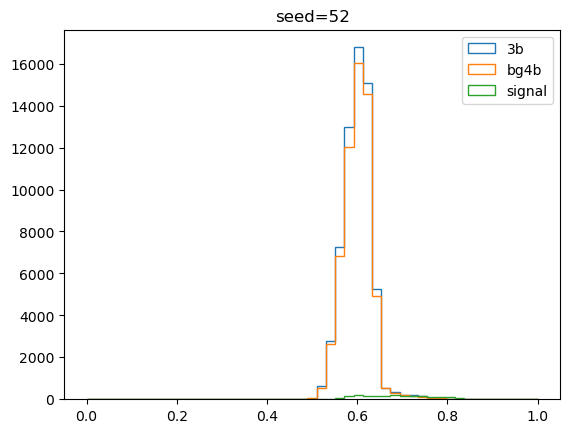

successfully loaded {'experiment_name': 'fvt_training_n_samples_1', 'seed': 62, 'n_sample_ratio': 1.0}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 23: 100%|██████████| 65/65 [00:02<00:00, 32.45it/s, v_num=0, val_loss=0.675, train_loss=0.674]
CR w_4b / w_3b = 1.414138913154602
SR w_4b / w_3b = 1.524002194404602


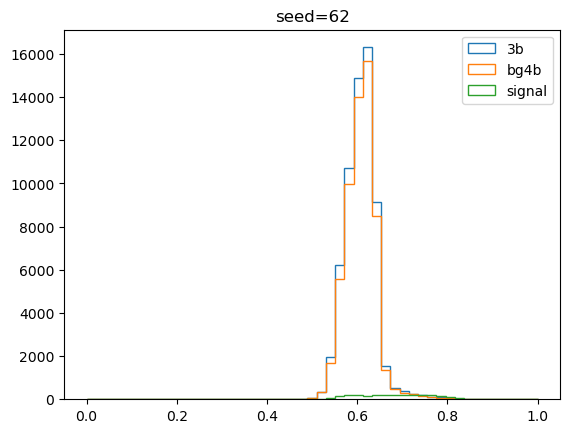

successfully loaded {'experiment_name': 'fvt_training_n_samples_1', 'seed': 72, 'n_sample_ratio': 1.0}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 18: 100%|██████████| 65/65 [00:02<00:00, 31.33it/s, v_num=0, val_loss=0.676, train_loss=0.674]
CR w_4b / w_3b = 1.388444423675537
SR w_4b / w_3b = 1.6401207447052002


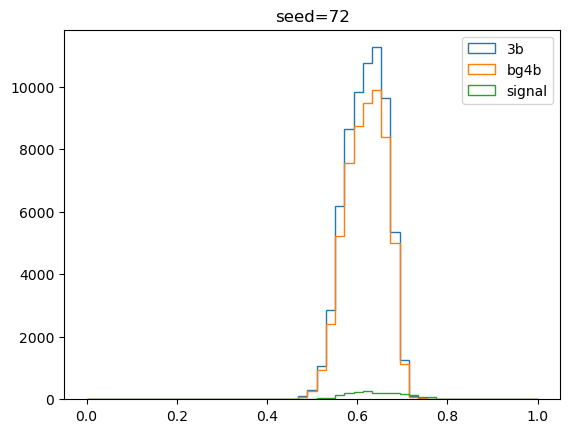

successfully loaded {'experiment_name': 'fvt_training_n_samples_1', 'seed': 82, 'n_sample_ratio': 1.0}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 23: 100%|██████████| 66/66 [00:01<00:00, 33.35it/s, v_num=0, val_loss=0.675, train_loss=0.674]
CR w_4b / w_3b = 1.3443433046340942
SR w_4b / w_3b = 1.4456543922424316


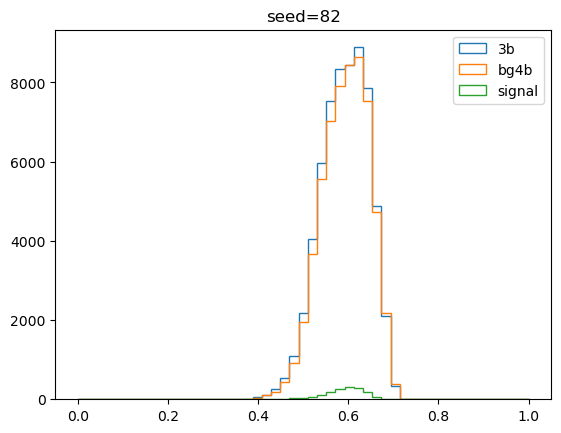

successfully loaded {'experiment_name': 'fvt_training_n_samples_1', 'seed': 92, 'n_sample_ratio': 1.0}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 29: 100%|██████████| 63/63 [00:02<00:00, 30.86it/s, v_num=0, val_loss=0.670, train_loss=0.669]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 63/63 [00:02<00:00, 29.14it/s, v_num=0, val_loss=0.670, train_loss=0.669]
CR w_4b / w_3b = 1.5086344480514526
SR w_4b / w_3b = 1.7721670866012573


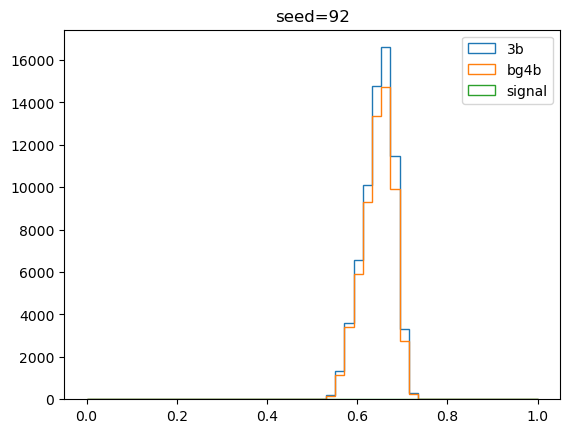

In [53]:
from signal_region import get_regions_stats
from fvt_classifier import FvTClassifier

noise_scale = 0.05
batch_size = 2**10
sr_w4b_ratio = 0.2
cr_w4b_ratio = 0.2

signal_region_stats_dict = {}

for seed in seeds:
    hparam_filter = {"experiment_name": experiment_name, 
                    "seed": seed, 
                    "n_sample_ratio": n_sample_ratio}
    hashes = TrainingInfo.find(hparam_filter)
    assert len(hashes) == 1
    print("successfully loaded", hparam_filter)
    fvt_hash = hashes[0]

    events_sr_train, events_sr_eval = events_test_dict[seed].split(1/3, seed=seed)

    signal_region_stats = get_regions_stats(
        events_sr_eval, fvt_hash, method="smearing", 
        events_sr_train=events_sr_train, noise_scale=noise_scale)    

    signal_region_stats_dict[seed] = signal_region_stats
    events_sr_eval.update_npd("smear_diff", signal_region_stats)

    signal_region_stats_argsort = np.argsort(signal_region_stats)[::-1]
    signal_region_stats_sorted = signal_region_stats[signal_region_stats_argsort]

    weights = events_sr_eval.weights[signal_region_stats_argsort]
    is_signal = events_sr_eval.is_signal[signal_region_stats_argsort]
    is_4b = events_sr_eval.is_4b[signal_region_stats_argsort]

    cumul_4b_ratio = np.cumsum(weights * is_4b) / np.sum(weights * is_4b)
    sr_cut = signal_region_stats_sorted[np.argmin(cumul_4b_ratio < sr_w4b_ratio)]
    cr_cut = signal_region_stats_sorted[np.argmin(cumul_4b_ratio < sr_w4b_ratio + cr_w4b_ratio)]

    events_svc_cr = events_sr_eval[(events_sr_eval.npd["smear_diff"] > cr_cut)
                                    & (events_sr_eval.npd["smear_diff"] < sr_cut)]
    events_svc_cr_train, events_svc_cr_val = events_svc_cr.split(2/3, seed=seed)
    events_svc_cr_train.fit_batch_size(batch_size)
    events_svc_cr_val.fit_batch_size(batch_size)

    events_svc_sr = events_sr_eval[events_sr_eval.npd["smear_diff"] >= sr_cut]

    svc_model = FvTClassifier(
        num_classes=2,
        dim_input_jet_features=4,
        dim_dijet_features=6,
        dim_quadjet_features=6,
        run_name=f"svc_tmp_{seed}",
        device=torch.device("cuda:0"),
        lr=1e-3
    )

    svc_model.fit(
        events_svc_cr_train.to_tensor_dataset(),
        events_svc_cr_val.to_tensor_dataset(),
        batch_size=batch_size,
        max_epochs=30,
    )

    svc_model.eval()
    svc_model.to(device)

    cr_w_4b_over_3b = events_svc_cr.total_weight_4b / (events_svc_cr.total_weight - events_svc_cr.total_weight_4b)
    sr_w_4b_over_3b = events_svc_sr.total_weight_4b / (events_svc_sr.total_weight - events_svc_sr.total_weight_4b)
    probs_4b = svc_model.predict(events_svc_sr.X_torch)[:, 1].cpu().numpy()

    print(f"CR w_4b / w_3b = {cr_w_4b_over_3b}")
    print(f"SR w_4b / w_3b = {sr_w_4b_over_3b}")

    events_svc_sr_reweighted = events_svc_sr.clone()
    reweights = (sr_w_4b_over_3b / cr_w_4b_over_3b) * (probs_4b / (1 - probs_4b))
    events_svc_sr_reweighted.reweight(
        np.where(
        events_svc_sr_reweighted.is_4b, 
        events_svc_sr_reweighted.weights,
        events_svc_sr_reweighted.weights * reweights,
    ))

    is_3b = events_svc_sr_reweighted.is_3b
    is_bg4b = events_svc_sr_reweighted.is_bg4b
    is_signal = events_svc_sr_reweighted.is_signal

    bins_range = np.linspace(0, 1, 50)

    plt.title(f"seed={seed}")
    plt.hist(events_svc_sr_reweighted.fvt_score[is_3b], bins=bins_range, histtype="step", 
                label="3b", weights=events_svc_sr_reweighted.weights[is_3b])
    plt.hist(events_svc_sr_reweighted.fvt_score[is_bg4b], bins=bins_range, histtype="step", 
                label="bg4b", weights=events_svc_sr_reweighted.weights[is_bg4b])
    plt.hist(events_svc_sr_reweighted.fvt_score[is_signal], bins=bins_range, histtype="step", 
                label="signal", weights=events_svc_sr_reweighted.weights[is_signal])
    # plt.yscale("log")
    plt.legend()
    plt.show()


CR w_4b / w_3b = 1.3810327053070068
SR w_4b / w_3b = 1.5039342641830444


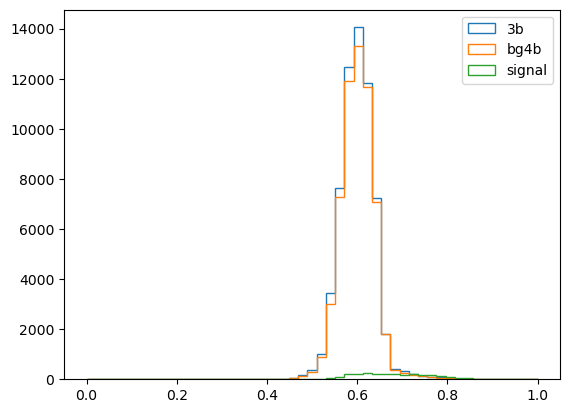